# Goal Clustering with New Simulation

In [27]:
import sys
import os


# Get the absolute path to the directory containing 'src'
project_dir = os.path.abspath("..")
sys.path.append(project_dir)

In [28]:
from src.simulation.simulation_space import DestinationPoint, StartingPoint, SimulationSpace
from src.simulation.agent import Agent
from src.simulation.simulation import Simulation

In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


Simulation complete! All agents have reached their destinations.


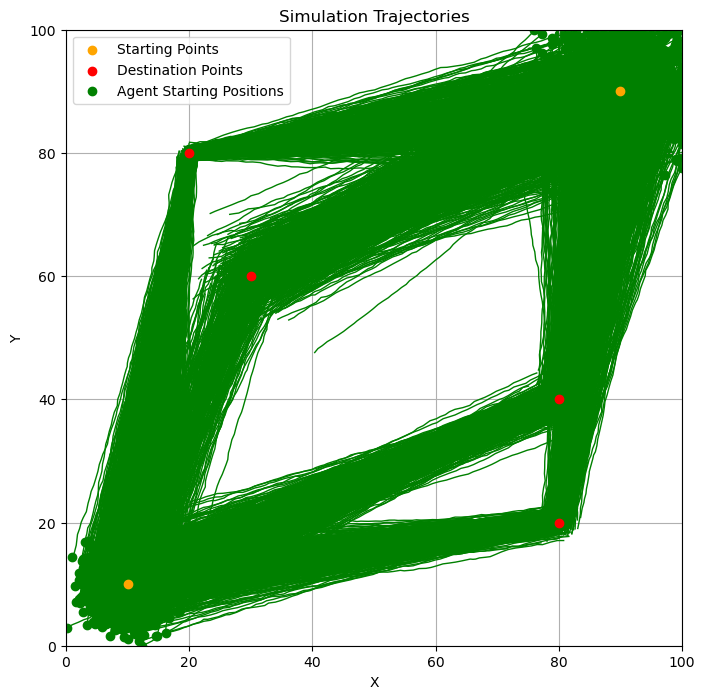

In [30]:
# Define destination points with the new stopping point logic
destination_1 = DestinationPoint(x=20, y=80, stop_mean=2.0, stop_std=0.5)
destination_2 = DestinationPoint(x=80, y=20, stop_mean=5.0, stop_std=1.0)
destination_3 = DestinationPoint(x=80, y=40, stop_mean=3.0, stop_std=1.5)
destination_4 = DestinationPoint(x=30, y=60, stop_mean=5.0, stop_std=3.0)


# Initialize the simulation space
space = SimulationSpace(size=(100, 100), destination_points=[destination_1, destination_2, destination_3, destination_4])

# Add starting points
starting_point_1 = StartingPoint(x=10, y=10, simulation_space=space, position_std=3.0, destination_probs=[0.5, 0.2, .2, .1])
starting_point_2 = StartingPoint(x=90, y=90, simulation_space=space, position_std=5.0, destination_probs=[0.2, 0.3, .2, .3])
space.add_starting_point(starting_point_1)
space.add_starting_point(starting_point_2)

# Create agents
agents = []
for _ in range(5000):  # Generate agents
    agent = Agent(simulation_space=space)
    agent.initialize_agent()
    agents.append(agent)

# Add agents to the simulation space
for agent in agents:
    space.add_agent(agent)

# Run the simulation
simulation = Simulation(simulation_space=space, agents=agents)
simulation.run_simulation()

# Visualize the trajectories
simulation.visualize_trajectories()
trajectories = simulation.trajectories

Simulation complete! All agents have reached their destinations.


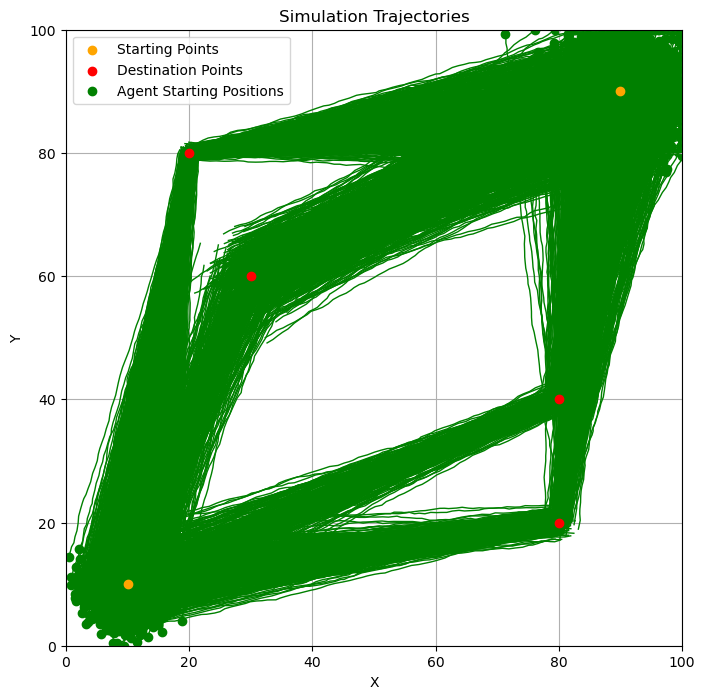

In [31]:
# Define destination points with the new stopping point logic
destination_1 = DestinationPoint(x=20, y=80, stop_mean=3.0, stop_std=0.5)
destination_2 = DestinationPoint(x=80, y=20, stop_mean=4.0, stop_std=1.0)
destination_3 = DestinationPoint(x=80, y=40, stop_mean=2.0, stop_std=1.0)
destination_4 = DestinationPoint(x=30, y=60, stop_mean=6.0, stop_std=3.0)


# Initialize the simulation space
space = SimulationSpace(size=(100, 100), destination_points=[destination_1, destination_2, destination_3, destination_4])

# Add starting points
starting_point_1 = StartingPoint(x=10, y=10, simulation_space=space, position_std=3.0, destination_probs=[0.6, 0.2, .1, .1])
starting_point_2 = StartingPoint(x=90, y=90, simulation_space=space, position_std=5.0, destination_probs=[0.2, 0.1, .3, .4])
space.add_starting_point(starting_point_1)
space.add_starting_point(starting_point_2)

# Create agents
agents = []
for _ in range(5000):  # Generate agents
    agent = Agent(simulation_space=space)
    agent.initialize_agent()
    agents.append(agent)

# Add agents to the simulation space
for agent in agents:
    space.add_agent(agent)

# Run the simulation
simulation = Simulation(simulation_space=space, agents=agents)
simulation.run_simulation()

# Visualize the trajectories
simulation.visualize_trajectories()
test_trajectories = simulation.trajectories

## Initial Clustering for Destination Points

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Extract destination points
def extract_destination_points(trajectories):
    """
    Extract destination points (last points) from trajectories.

    Parameters:
        trajectories (dict): Dictionary of trajectories {id: [(x1, y1), (x2, y2), ...]}.

    Returns:
        np.ndarray: Array of destination points, shape (num_trajectories, 2).
    """
    destination_points = np.array([traj[-1] for traj in trajectories.values()])
    return destination_points

destination_points = extract_destination_points(trajectories)
print(f"Destination Points Shape: {destination_points.shape}")

Destination Points Shape: (5000, 2)


In [33]:
# Apply K-Means clustering
num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(destination_points)

# Assign cluster labels back to trajectories
trajectory_clusters = {key: cluster_labels[idx] for idx, key in enumerate(trajectories.keys())}

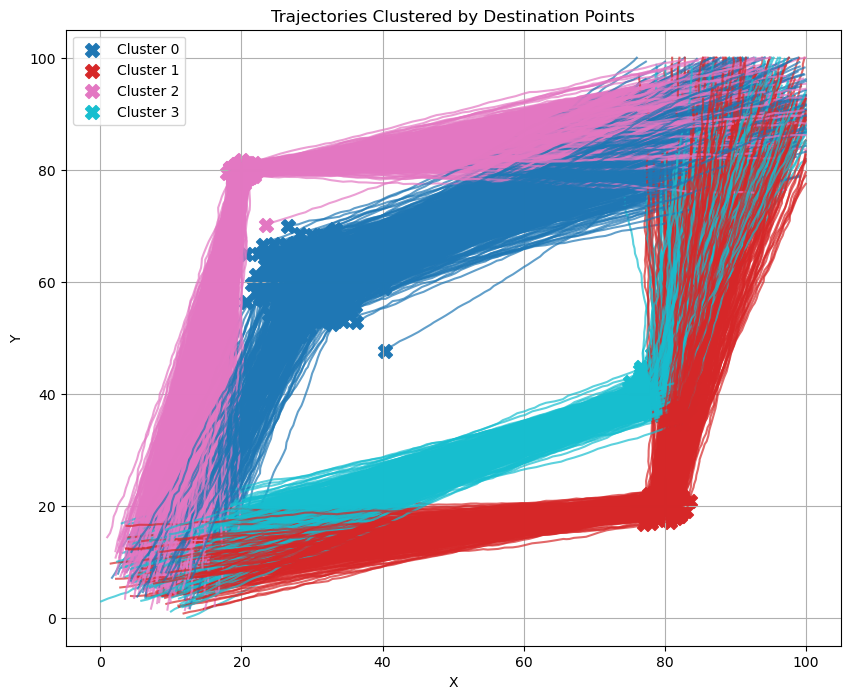

In [34]:
# Visualize clustered destinations and trajectories
colors = plt.cm.tab10(np.linspace(0, 1, num_clusters))

plt.figure(figsize=(10, 8))

# Plot trajectories with cluster colors
for traj_id, traj in trajectories.items():
    cluster_id = trajectory_clusters[traj_id]
    plt.plot(*zip(*traj), color=colors[cluster_id], alpha=0.7)

# Plot destination points with cluster colors and add to legend
for cluster_id in range(num_clusters):
    plt.scatter(
        destination_points[cluster_labels == cluster_id, 0], 
        destination_points[cluster_labels == cluster_id, 1], 
        c=[colors[cluster_id]], 
        label=f"Cluster {cluster_id}",
        s=100,
        marker="X"
    )

plt.title("Trajectories Clustered by Destination Points")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend(loc="best")
plt.grid()
plt.show()

In [35]:
goals = kmeans.cluster_centers_

## Training an RNN

In [43]:
import numpy as np
import torch
from torch.utils.data import Dataset

def interpolate_trajectory(trajectory, target_length):
    original_length = len(trajectory)
    trajectory = np.array(trajectory)

    # Create evenly spaced indices for the original and target trajectories
    original_indices = np.linspace(0, original_length - 1, num=original_length)
    target_indices = np.linspace(0, original_length - 1, num=target_length)

    # Interpolate x and y coordinates separately
    x = np.interp(target_indices, original_indices, trajectory[:, 0])
    y = np.interp(target_indices, original_indices, trajectory[:, 1])

    return np.column_stack((x, y))  # Combine x and y into a single array

class TrajectoryGoalDataset(Dataset):
    def __init__(self, trajectories, trajectory_clusters, max_len):
        """
        Dataset for trajectory-to-goal mapping.

        Parameters:
            trajectories (dict): Dictionary of trajectories {id: [(x1, y1), (x2, y2), ...]}.
            trajectory_clusters (dict): Dictionary of cluster labels {id: cluster_label}.
            max_len (int): Maximum trajectory length for padding or truncation.
        """
        self.inputs = []
        self.targets = []
        self.max_len = max_len


        # Prepare data and labels
        for traj_id, traj in trajectories.items():
            interpolated_traj = interpolate_trajectory(traj, max_len)
            self.inputs.append(interpolated_traj)
            self.targets.append(trajectory_clusters[traj_id])

        # Convert to single numpy array first, then to tensor
        self.inputs = torch.tensor(np.array(self.inputs), dtype=torch.float32)  # Shape: (num_trajectories, max_len, 2)
        self.targets = torch.tensor(self.targets, dtype=torch.long)  # Shape: (num_trajectories,)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx]

# Calculate the maximum trajectory length from both datasets
max_len_train = max(len(traj) for traj in trajectories.values())
max_len_test = max(len(traj) for traj in test_trajectories.values())
max_len = max(max_len_train, max_len_test)  # Use the longest length across both datasets

# Prepare the datasets
train_dataset = TrajectoryGoalDataset(trajectories, trajectory_clusters, max_len)
test_dataset = TrajectoryGoalDataset(test_trajectories, trajectory_clusters, max_len)

# Print dataset shapes for verification
print(f"Training Data Shape: {train_dataset.inputs.shape}, Labels Shape: {train_dataset.targets.shape}")
print(f"Testing Data Shape: {test_dataset.inputs.shape}, Labels Shape: {test_dataset.targets.shape}")


AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [44]:
import torch
import torch.nn as nn

class SimpleRNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1):
        """
        A simple RNN for trajectory-to-goal classification.

        Parameters:
            input_dim (int): Dimension of input features (e.g., 2 for x, y coordinates).
            hidden_dim (int): Dimension of the hidden state.
            output_dim (int): Number of output classes (e.g., 2 for two goals).
            num_layers (int): Number of RNN layers (default is 1).
        """
        super(SimpleRNN, self).__init__()
        
        self.rnn = nn.RNN(input_dim, hidden_dim, num_layers, batch_first=True, nonlinearity='tanh')
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.hidden_dim = hidden_dim

    def forward(self, x):
        """
        Forward pass through the RNN.
        
        Parameters:
            x (torch.Tensor): Input tensor of shape (batch_size, seq_len, input_dim).

        Returns:
            torch.Tensor: Output logits of shape (batch_size, output_dim).
        """
        # RNN returns the hidden states for all time steps and the final hidden state
        batch_size = x.size(0)
        h0 = torch.zeros(self.rnn.num_layers, batch_size, self.hidden_dim, device=x.device)
        out, _ = self.rnn(x, h0)  # `out` shape: (batch_size, seq_len, hidden_dim)
        
        # Use only the last hidden state for classification
        last_hidden_state = out[:, -1, :]  # Shape: (batch_size, hidden_dim)
        logits = self.fc(last_hidden_state)  # Shape: (batch_size, output_dim)
        
        return logits

In [45]:
# Define the model, loss function, and optimizer
input_dim = 2  # x, y coordinates
hidden_dim = 64  # Adjust based on experiment
output_dim = 4  # Number of goals
num_layers = 1  # Single-layer RNN

In [46]:
import torch.optim as optim
from torch.utils.data import DataLoader

model = SimpleRNN(input_dim, hidden_dim, output_dim, num_layers).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Hyperparameters
batch_size = 32
learning_rate = 1e-3
num_epochs = 20

# Define the dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()  # For classification
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Move model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    train_loss = 0.0

    for inputs, labels in train_loader:
        # Move data to the appropriate device
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    #if not (epoch+1) % 10:
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_train_loss:.4f}")


Epoch [1/20], Loss: 0.2693
Epoch [2/20], Loss: 0.0245
Epoch [3/20], Loss: 0.0133
Epoch [4/20], Loss: 0.0080
Epoch [5/20], Loss: 0.0051
Epoch [6/20], Loss: 0.0053
Epoch [7/20], Loss: 0.0034
Epoch [8/20], Loss: 0.0029
Epoch [9/20], Loss: 0.0025
Epoch [10/20], Loss: 0.0037
Epoch [11/20], Loss: 0.0022
Epoch [12/20], Loss: 0.0031
Epoch [13/20], Loss: 0.0025
Epoch [14/20], Loss: 0.0018
Epoch [15/20], Loss: 0.0047
Epoch [16/20], Loss: 0.0021
Epoch [17/20], Loss: 0.0016
Epoch [18/20], Loss: 0.0037
Epoch [19/20], Loss: 0.0016
Epoch [20/20], Loss: 0.0014


In [47]:
# Validation loop on training data
model.eval()  # Set model to evaluation mode
train_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in train_loader:  # Using the train_loader
        # Move data to the appropriate device
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        train_loss += loss.item()

        # Get predictions
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

avg_train_loss = train_loss / len(train_loader)
accuracy = correct / total * 100

print(f"Training Data Validation Loss: {avg_train_loss:.4f}, Accuracy: {accuracy:.2f}%")

Training Data Validation Loss: 0.0009, Accuracy: 99.96%


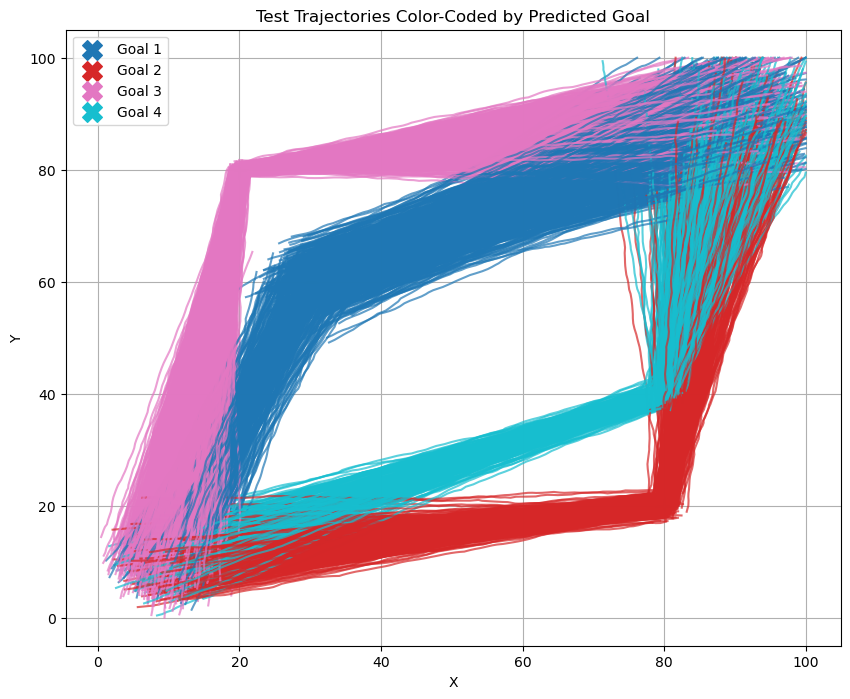

In [48]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Set the model to evaluation mode
model.eval()

# Store predictions and trajectory data
predicted_labels = []
test_trajectories = []

with torch.no_grad():
    for inputs, _ in test_loader:  # Assuming test_loader is defined for the test dataset
        inputs = inputs.to(device)  # Send to the same device as the model
        
        # Get predictions
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1)
        
        # Store the predictions
        predicted_labels.extend(preds.cpu().numpy())
        
        # Store trajectories for visualization
        test_trajectories.extend(inputs.cpu().numpy())

# Convert to numpy arrays for easier processing
predicted_labels = np.array(predicted_labels)
test_trajectories = np.array(test_trajectories)  # Shape: (num_trajectories, seq_len, 2)

# Visualization
colors = plt.cm.tab10(np.linspace(0, 1, 4))  # Use distinct colors for each goal

plt.figure(figsize=(10, 8))
for idx, trajectory in enumerate(test_trajectories):
    predicted_goal = predicted_labels[idx]
    plt.plot(trajectory[:, 0], trajectory[:, 1], color=colors[predicted_goal], alpha=0.7)

# Optionally plot the destination points for reference
for i, goal in enumerate(goals):  # Assuming `goals` is the list of goal destination points
    plt.scatter(goal[0], goal[1], color=colors[i], label=f"Goal {i + 1}", marker="X", s=200)

plt.title("Test Trajectories Color-Coded by Predicted Goal")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.grid()
plt.show()

/var/folders/38/k8ptv94x02v3qc6vywd5sfv40000gn/T/ipykernel_95794/4022584339.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1728928937407/work/torch/csrc/utils/tensor_new.cpp:281.)
  partial_trajectories = torch.tensor(partial_trajectories, dtype=torch.float32).to(device)


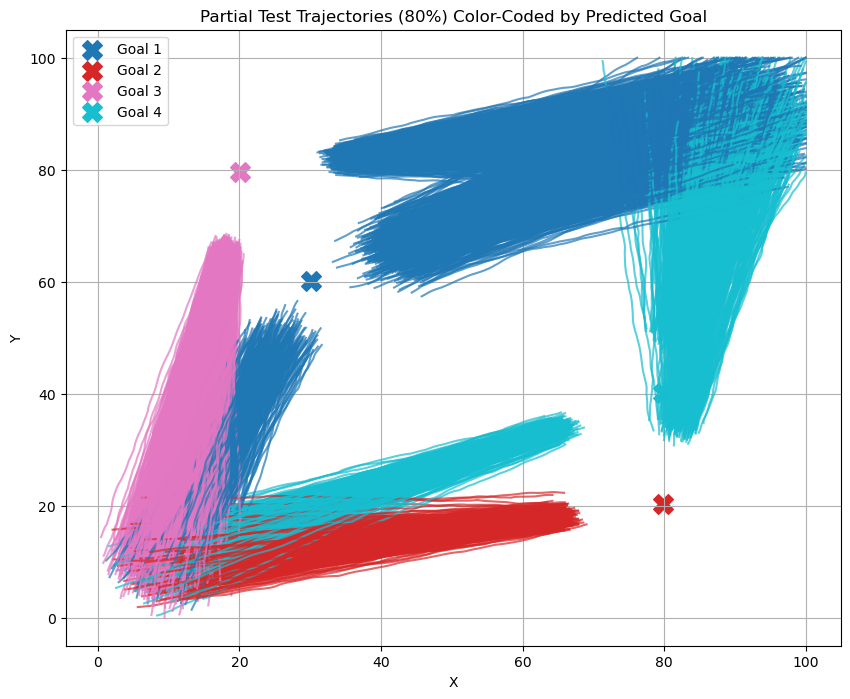

In [49]:
# Create partial trajectories for testing
partial_trajectories = []
for traj in test_trajectories:
    partial_length = int(0.8 * len(traj))  # Use the first 80% of the trajectory
    partial_traj = traj[:partial_length]  # Extract first 80%
    
    # Linearly interpolate to match the original max_len
    interpolated_traj = interpolate_trajectory(partial_traj, max_len)
    partial_trajectories.append(interpolated_traj)

# Convert to tensor for model prediction
partial_trajectories = torch.tensor(partial_trajectories, dtype=torch.float32).to(device)

# Predict goals for partial trajectories
model.eval()
with torch.no_grad():
    outputs = model(partial_trajectories)
    predicted_labels_partial = torch.argmax(outputs, dim=1).cpu().numpy()

# Visualization
colors = plt.cm.tab10(np.linspace(0, 1, num_clusters))  # Use distinct colors for each goal

plt.figure(figsize=(10, 8))
for idx, trajectory in enumerate(partial_trajectories.cpu().numpy()):
    predicted_goal = predicted_labels_partial[idx]
    plt.plot(trajectory[:, 0], trajectory[:, 1], color=colors[predicted_goal], alpha=0.7)

# Optionally plot the destination points for reference
for i, goal in enumerate(goals):  # Assuming `goals` is the list of goal destination points
    plt.scatter(goal[0], goal[1], color=colors[i], label=f"Goal {i + 1}", marker="X", s=200)

plt.title("Partial Test Trajectories (80%) Color-Coded by Predicted Goal")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.grid()
plt.show()

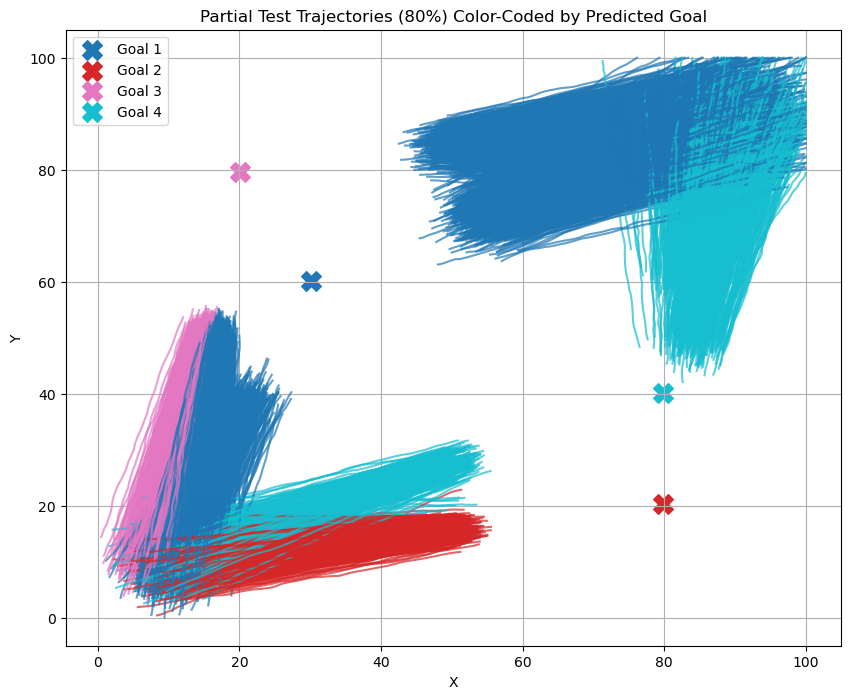

In [50]:
# Create partial trajectories for testing
partial_trajectories = []
for traj in test_trajectories:
    partial_length = int(0.6 * len(traj))  # Use the first 80% of the trajectory
    partial_traj = traj[:partial_length]  # Extract first 80%
    
    # Linearly interpolate to match the original max_len
    interpolated_traj = interpolate_trajectory(partial_traj, max_len)
    partial_trajectories.append(interpolated_traj)

# Convert to tensor for model prediction
partial_trajectories = torch.tensor(partial_trajectories, dtype=torch.float32).to(device)

# Predict goals for partial trajectories
model.eval()
with torch.no_grad():
    outputs = model(partial_trajectories)
    predicted_labels_partial = torch.argmax(outputs, dim=1).cpu().numpy()

# Visualization
colors = plt.cm.tab10(np.linspace(0, 1, num_clusters))  # Use distinct colors for each goal

plt.figure(figsize=(10, 8))
for idx, trajectory in enumerate(partial_trajectories.cpu().numpy()):
    predicted_goal = predicted_labels_partial[idx]
    plt.plot(trajectory[:, 0], trajectory[:, 1], color=colors[predicted_goal], alpha=0.7)

# Optionally plot the destination points for reference
for i, goal in enumerate(goals):  # Assuming `goals` is the list of goal destination points
    plt.scatter(goal[0], goal[1], color=colors[i], label=f"Goal {i + 1}", marker="X", s=200)

plt.title("Partial Test Trajectories (80%) Color-Coded by Predicted Goal")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.grid()
plt.show()